In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

# Introduction

In this article I want to explore the topic of Design of Experiments. First of all we should ask ourselves how do we know more about a system?
The only way to know more or learn something about a system is to disturb it and then observe it. This is the basis of machine learning actually.
Ideally you want your algorithm to learn patterns in your data after all possible disturbances you may have, and with all variables you can find for your experiments.
But if you are to design a new experiment to learn from your system you probably can't afford to wait one year to collect enough data or explore all possible variables combinations in a random manner. There is a scientific way to do it which is proved to give you the best result. This approach or system is called Design of Experiment.

Imagine you want to understand which configuration is better for boiling water, with some parameters which you are free to control:

1) Heater Settings (Low/High)
2) Pot Type (Metal/Glass)
3) LID (with/without)
4) Heater Kind (gas/electric)

this very simple system, of which you may already know the answer, has 4 parameters, each with 2 possible states. So the total number of experiments you can do to explore all of them is 2^4 = 16 experiments.
But what I mean with "better" ? We have to define the objective which might be:
A) the faster way for boiling water -> I want to minimize it
B) the cheaper way for boiling water -> I want to minimize the cost
The outcome of our experiment is therefore either PRICE or TIME.

I said "parameters" above: Parameters, variables, factors, features in data science / statistics / research there are a lot of synonyms. They can be numerical or categorical.
We will explore a simple basic example doing the calculation by hand and getting a bit of help with python to display some data, and then we will try to do the same in a more automatic way in a more complicated system.
In the second part we will try to apply some powerful statistical tools to explore our data and make the first regressions, starting with OLS and then trying to explore more of our data with PCA/PCR and PLS. Finally we will try to apply some machine learning algorithm to the very same data.

## Two factors experiment

In [7]:
Light = ['On','Off']
Watering = ['Low','High']
# create combinations for all parameters
experiments = [(x,y) for x in Light for y in Watering]
exp_df = pd.DataFrame(experiments,columns=['A','B'])

In [8]:
exp_df

,A,B
0,On,Low
1,On,High
2,Off,Low
3,Off,High


In [10]:
# map the variable and encode them to ±1 
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['On','Off'],['Low','High']])

encoded_df = pd.DataFrame(enc.fit_transform(exp_df[['A','B']]),columns=['A','B'])
#define the experiments order which must be random
encoded_df['exp_order'] = np.random.choice(np.arange(4),4,replace=False)
encoded_df['outcome'] = [25,37,55,65]
encoded_df

,A,B,exp_order,outcome
0,0.0,0.0,3,25
1,0.0,1.0,0,37
2,1.0,0.0,2,55
3,1.0,1.0,1,65


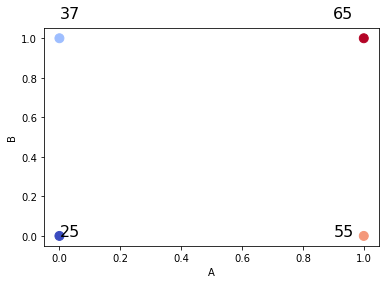

In [11]:
plt.scatter(encoded_df['A'],encoded_df['B'], marker='o', s=80, c=encoded_df['outcome'], cmap='coolwarm')
plt.xlabel('A')
plt.ylabel('B')
for i, txt in enumerate(encoded_df['outcome']):
    plt.annotate(txt, (encoded_df['A'].iloc[i], encoded_df['B'].iloc[i]),xytext=(encoded_df['A'].iloc[i]*0.9, encoded_df['B'].iloc[i]*1.1), fontsize=16)

In [12]:
average_response = encoded_df['outcome'].mean()

In [13]:
def Pars_effect(data = encoded_df, par='A', effect='B'):
    data_1 = data[data[par] == data[par].min()]
    data_2 = data[data[par] == data[par].max()]
    
    eff_1 = (data_1[data_1[effect] == data_1[effect].max()].outcome.max() - data_1[data_1[effect] == data_1[effect].min()].outcome.max())
    eff_2 = (data_2[data_2[effect] == data_2[effect].max()].outcome.max() - data_2[data_2[effect] == data_2[effect].min()].outcome.max())
    return (eff_2+eff_1)/2

def predict_outcome(baseline, A, Ax, B, Bx):
    if A == 0:
        A = -1
    if B == 0:
        B = -1
    print(f'y ~ {baseline}+1/2 {Ax}*A + 1/2 {Bx}*B')
    pred_y = baseline + 1/2*Ax*A + 1/2*Bx*B
    print(f'{pred_y}')
    return pred_y

In [19]:
Ax = Pars_effect(data = encoded_df, par='B', effect='A')
Bx = Pars_effect(data = encoded_df, par='A', effect='B')

In [17]:
y_pred_11 = predict_outcome(average_response,1,Ax,1,Bx)

y ~ 45.5+1/2 29.0*A + 1/2 11.0*B
65.5


In [18]:
y_pred_00 = predict_outcome(average_response,0,Ax,0,Bx)

y ~ 45.5+1/2 29.0*A + 1/2 11.0*B
25.5


In [16]:
average_response

45.5

In [107]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [108]:
results = smf.ols('outcome ~ A + B', data=encoded_df).fit()

In [109]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     481.0
Date:                Sun, 21 Mar 2021   Prob (F-statistic):             0.0322
Time:                        11:22:47   Log-Likelihood:                -2.9032
No. Observations:                   4   AIC:                             11.81
Df Residuals:                       1   BIC:                             9.965
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.5000      0.500     91.000      0.0

C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<AxesSubplot:xlabel='A', ylabel='outcome'>

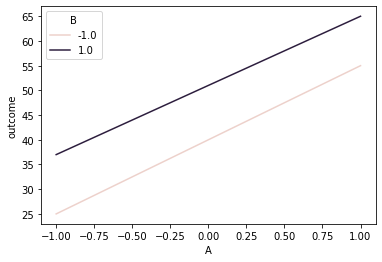

In [110]:
sns.lineplot(x='A',y='outcome',hue='B',data=encoded_df)

In [111]:
encoded_df

,A,B,exp_order,outcome
0,-1.0,-1.0,3,25
1,-1.0,1.0,0,37
2,1.0,-1.0,2,55
3,1.0,1.0,1,65


In [112]:
A = np.matrix(encoded_df[['A','B']])
A = np.c_[ A, np.ones(len(A))]
b = np.array(encoded_df['outcome'])
print(np.linalg.lstsq(A,b, rcond=None))
print((np.linalg.inv(A.T*A)*A.T)*b.reshape(-1,1))

(array([14.5,  5.5, 45.5]), array([1.]), 3, array([2., 2., 2.]))
[[14.5]
 [ 5.5]
 [45.5]]


In [113]:
encoded_df['A'].replace(0, -1, inplace=True)
encoded_df['B'].replace(0, -1, inplace=True)

In [114]:
encoded_df

,A,B,exp_order,outcome
0,-1.0,-1.0,3,25
1,-1.0,1.0,0,37
2,1.0,-1.0,2,55
3,1.0,1.0,1,65


In [115]:
A = np.matrix(encoded_df[['A','B']])
A = np.c_[ A, np.ones(len(A))]
b = np.array(encoded_df['outcome'])
print(np.linalg.lstsq(A,b, rcond=None))
print((np.linalg.inv(A.T*A)*A.T)*b.reshape(-1,1))

(array([14.5,  5.5, 45.5]), array([1.]), 3, array([2., 2., 2.]))
[[14.5]
 [ 5.5]
 [45.5]]


## Negative Interaction

In [134]:
encoded_df_int = pd.DataFrame(enc.fit_transform(exp_df[['A','B']]),columns=['A','B'])
encoded_df_int['exp_order'] = np.random.choice(np.arange(4),4,replace=False)
encoded_df_int['outcome'] = [21,23,25,44]
average_int_resp = encoded_df_int['outcome'].mean()
Ax = Pars_effect(data = encoded_df_int, par='B', effect='A')
Bx = Pars_effect(data = encoded_df_int, par='A', effect='B')
y_pred_11 = predict_outcome(average_response,1,Ax,1,Bx)
y_pred_00 = predict_outcome(average_response,0,Ax,0,Bx)

y ~ 45.5+1/2 12.5*A + 1/2 10.5*B
57.0
y ~ 45.5+1/2 12.5*A + 1/2 10.5*B
34.0


In [135]:
results = smf.ols('outcome ~ A + B', data=encoded_df_int).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     1.844
Date:                Sun, 21 Mar 2021   Prob (F-statistic):              0.462
Time:                        11:26:42   Log-Likelihood:                -11.463
No. Observations:                   4   AIC:                             28.93
Df Residuals:                       1   BIC:                             27.09
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.7500      7.361      2.275      0.2

C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [139]:
A = np.matrix(encoded_df_int[['A','B']])
A = np.c_[np.ones(len(A)), A ]
b = np.array(encoded_df_int['outcome'])
print(np.linalg.lstsq(A,b, rcond=None))

(array([16.75, 12.5 , 10.5 ]), array([72.25]), 3, array([2.5243378 , 1.        , 0.79228699]))


In [140]:
# print((np.linalg.inv(A.T*A)*A.T)*b.reshape(-1,1))
# print((np.linalg.inv(A.T*A)*A.T)*b.reshape(-1,1))
encoded_df_int['A*B'] = encoded_df_int['A']*encoded_df_int['B']
encoded_df_int

,A,B,exp_order,outcome,A*B
0,0.0,0.0,0,21,0.0
1,0.0,1.0,2,23,0.0
2,1.0,0.0,1,25,0.0
3,1.0,1.0,3,44,1.0


In [144]:
A = np.matrix(encoded_df_int[['A','B','A*B']])
A = np.c_[np.ones(len(A)), A ]
b = np.array(encoded_df_int['outcome'])
print(np.linalg.lstsq(A,b, rcond=None,)[:2])

(array([21.,  4.,  2., 17.]), array([], dtype=float64))


In [147]:
results = smf.ols('outcome ~ A + B + A*B', data=encoded_df_int).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 21 Mar 2021   Prob (F-statistic):                nan
Time:                        11:31:46   Log-Likelihood:                 121.03
No. Observations:                   4   AIC:                            -234.1
Df Residuals:                       0   BIC:                            -236.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.0000        inf          0        n

C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [148]:
results = smf.ols('outcome ~ A*B', data=encoded_df_int).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 21 Mar 2021   Prob (F-statistic):                nan
Time:                        11:31:55   Log-Likelihood:                 121.03
No. Observations:                   4   AIC:                            -234.1
Df Residuals:                       0   BIC:                            -236.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.0000        inf          0        n

C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


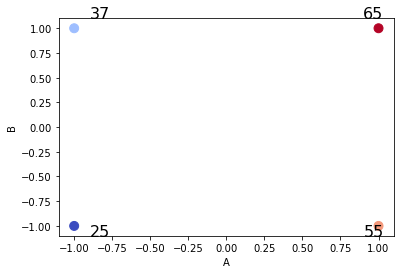

In [149]:
plt.scatter(encoded_df['A'],encoded_df['B'], marker='o', s=80, c=encoded_df['outcome'], cmap='coolwarm')
plt.xlabel('A')
plt.ylabel('B')
for i, txt in enumerate(encoded_df['outcome']):
    plt.annotate(txt, (encoded_df['A'].iloc[i], encoded_df['B'].iloc[i]),xytext=(encoded_df['A'].iloc[i]*0.9, encoded_df['B'].iloc[i]*1.1), fontsize=16)

<AxesSubplot:xlabel='A', ylabel='outcome'>

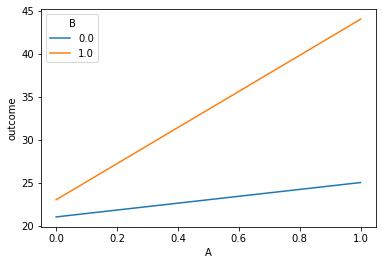

In [150]:
sns.lineplot(x='A',y='outcome',hue='B',data=encoded_df_int)

In [151]:
def Pars_effect_interaction(data = encoded_df, par='A', effect='B', verbose=True):
    
    data_1 = data[data[par] == data[par].min()].copy()
    data_2 = data[data[par] == data[par].max()].copy()
    if verbose:
        display(data_1)
        display(data_2)
        
    eff_1 = (data_1[data_1[effect] == data_1[effect].max()].outcome.max() - data_1[data_1[effect] == data_1[effect].min()].outcome.max())
    eff_2 = (data_2[data_2[effect] == data_2[effect].max()].outcome.max() - data_2[data_2[effect] == data_2[effect].min()].outcome.max())
    
    return (max(eff_1,eff_2)-min(eff_1,eff_2))/2

def predict_outcome_int(baseline, A, Ax, B, Bx, *args):
    if A == 0:
        A = -1
    if B == 0:
        B = -1
        
    if args:
        ABx = args[0]
        print(f'y ~ {baseline}+1/2 {Ax}*A + 1/2 {Bx}*B + 1/2 {ABx} *A*B')
    else:
        ABx=0
        print(f'y ~ {baseline}+1/2 {Ax}*A + 1/2 {Bx}*B')
        
    pred_y = baseline + 1/2*Ax*A + 1/2*Bx*B +1/2 *A*B*ABx
    print(f'{pred_y}')
    return pred_y

In [152]:
max(2,5)

5

In [153]:
Ax_int = Pars_effect_interaction(data = encoded_df_int, par='B', effect='A', verbose=False)
Bx_int = Pars_effect_interaction(data = encoded_df_int, par='A', effect='B', verbose=True)
Ax_int,Bx_int

,A,B,exp_order,outcome,A*B
0,0.0,0.0,0,21,0.0
1,0.0,1.0,2,23,0.0


,A,B,exp_order,outcome,A*B
2,1.0,0.0,1,25,0.0
3,1.0,1.0,3,44,1.0


(8.5, 8.5)

In [154]:
encoded_df_int

,A,B,exp_order,outcome,A*B
0,0.0,0.0,0,21,0.0
1,0.0,1.0,2,23,0.0
2,1.0,0.0,1,25,0.0
3,1.0,1.0,3,44,1.0


In [155]:
predict_outcome_int(average_int_resp,1,Ax,1,Bx,Ax_int)

y ~ 28.25+1/2 12.5*A + 1/2 10.5*B + 1/2 8.5 *A*B
44.0


44.0

In [156]:
predict_outcome_int(average_int_resp,0,Ax,0,Bx,Ax_int)

y ~ 28.25+1/2 12.5*A + 1/2 10.5*B + 1/2 8.5 *A*B
21.0


21.0

In [168]:
df2 = pd.DataFrame(enc.fit_transform(exp_df[['A','B']]),columns=['A','B'])
df2['exp_order'] = np.random.choice(np.arange(4),4,replace=False)
df2['outcome'] = [20,23.5,25.5,44.5]
df2['A*B'] = df2['A']*df2['B']
df2

,A,B,exp_order,outcome,A*B
0,0.0,0.0,1,20.0,0.0
1,0.0,1.0,2,23.5,0.0
2,1.0,0.0,3,25.5,0.0
3,1.0,1.0,0,44.5,1.0


In [173]:
df2[df2.A!=df2.B]

,A,B,exp_order,outcome,A*B
1,0.0,1.0,2,23.5,0.0
2,1.0,0.0,3,25.5,0.0


In [181]:
df_all = pd.concat([encoded_df_int,df2[df2.A!=df2.B]]).drop('exp_order',1)
df_all

,A,B,outcome,A*B
0,0.0,0.0,21.0,0.0
1,0.0,1.0,23.0,0.0
2,1.0,0.0,25.0,0.0
3,1.0,1.0,44.0,1.0
1,0.0,1.0,23.5,0.0
2,1.0,0.0,25.5,0.0


<AxesSubplot:xlabel='A', ylabel='outcome'>

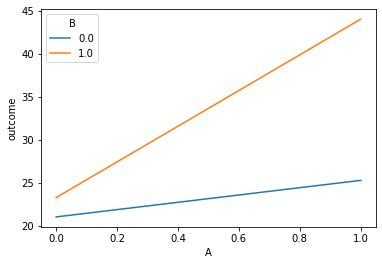

In [182]:
sns.lineplot(x='A',y='outcome',hue='B',data=df_all)

In [183]:
results = smf.ols('outcome ~ A*B', data=df_all).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     958.0
Date:                Sun, 21 Mar 2021   Prob (F-statistic):            0.00104
Time:                        11:39:51   Log-Likelihood:                 1.0205
No. Observations:                   6   AIC:                             5.959
Df Residuals:                       2   BIC:                             5.126
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.0000      0.354     59.397      0.0

C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [184]:
df_all = pd.concat([encoded_df_int,df2[df2.A==df2.B]]).drop('exp_order',1)
results = smf.ols('outcome ~ A*B', data=df_all).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     703.6
Date:                Sun, 21 Mar 2021   Prob (F-statistic):            0.00142
Time:                        11:40:01   Log-Likelihood:                -1.7283
No. Observations:                   6   AIC:                             11.46
Df Residuals:                       2   BIC:                             10.62
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.5000      0.395     51.861      0.0

C:\Users\castian001\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
